## **Введение в анализ данных**
## **НИУ ВШЭ, 2019-2020 учебный год**
###**Домашнее задание №4**
Задание выполнила: Густомясова Софья 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from seaborn import barplot
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

**0.(0 баллов)** Загрузите датасет, в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [5]:
# загрузка файла в ноутбук
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format( name=fn, length=len(uploaded[fn])))

Saving diabetes.csv to diabetes (1).csv
User uploaded file "diabetes.csv" with length 23873 bytes


In [6]:
data = pd.read_csv('./diabetes.csv')

In [7]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
data.shape

(768, 9)

In [9]:
data.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

Пропусков нет.

**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [10]:
for column in data.columns:
  print((data[column]==0).value_counts())
  print()


False    657
True     111
Name: Pregnancies, dtype: int64

False    763
True       5
Name: Glucose, dtype: int64

False    733
True      35
Name: BloodPressure, dtype: int64

False    541
True     227
Name: SkinThickness, dtype: int64

False    394
True     374
Name: Insulin, dtype: int64

False    757
True      11
Name: BMI, dtype: int64

False    768
Name: DiabetesPedigreeFunction, dtype: int64

False    768
Name: Age, dtype: int64

True     500
False    268
Name: Outcome, dtype: int64



In [11]:
data.mean()

Pregnancies                   3.845052
Glucose                     120.894531
BloodPressure                69.105469
SkinThickness                20.536458
Insulin                      79.799479
BMI                          31.992578
DiabetesPedigreeFunction      0.471876
Age                          33.240885
Outcome                       0.348958
dtype: float64

True соответствует количеству 0 в данном столбце. Таким образом, нулевые значения есть во всех столбцах кроме DiabetesPedigreeFunction и Age. В столбцах Pregnancies (количество беременностей) и Outcome нулевые значения предполагаются логикой данных переменных. В столбцах Insulin и SkinThickness с медицинской точки зрения не предполагаются нулевые значения, но так как их очень много, пропуски в данном случае могут быть важным признаком, поэтому в этих столбцах я тоже не буду заменять нулевые значения. В оставшихся столбцах 'Glucose','BloodPressure','BMI'  я заменю нулевые значения средними с помощью SimpleImputer. 

In [12]:
replacer = SimpleImputer(missing_values=0, strategy='mean')
data_replace=pd.DataFrame(data=replacer.fit_transform(data[['Glucose','BloodPressure','BMI']]), columns=['Glucose','BloodPressure','BMI'])

In [13]:
data[['Glucose','BloodPressure','BMI']]=data_replace

In [14]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35,0,33.6,0.627,50,1
1,1,85.0,66.0,29,0,26.6,0.351,31,0
2,8,183.0,64.0,0,0,23.3,0.672,32,1
3,1,89.0,66.0,23,94,28.1,0.167,21,0
4,0,137.0,40.0,35,168,43.1,2.288,33,1


In [15]:
data.mean()

Pregnancies                   3.845052
Glucose                     121.686763
BloodPressure                72.405184
SkinThickness                20.536458
Insulin                      79.799479
BMI                          32.457464
DiabetesPedigreeFunction      0.471876
Age                          33.240885
Outcome                       0.348958
dtype: float64

Если сравнить со средними значениями до изменений видно, что они (средние значения) изменились только там, где и предполагалось.

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых.

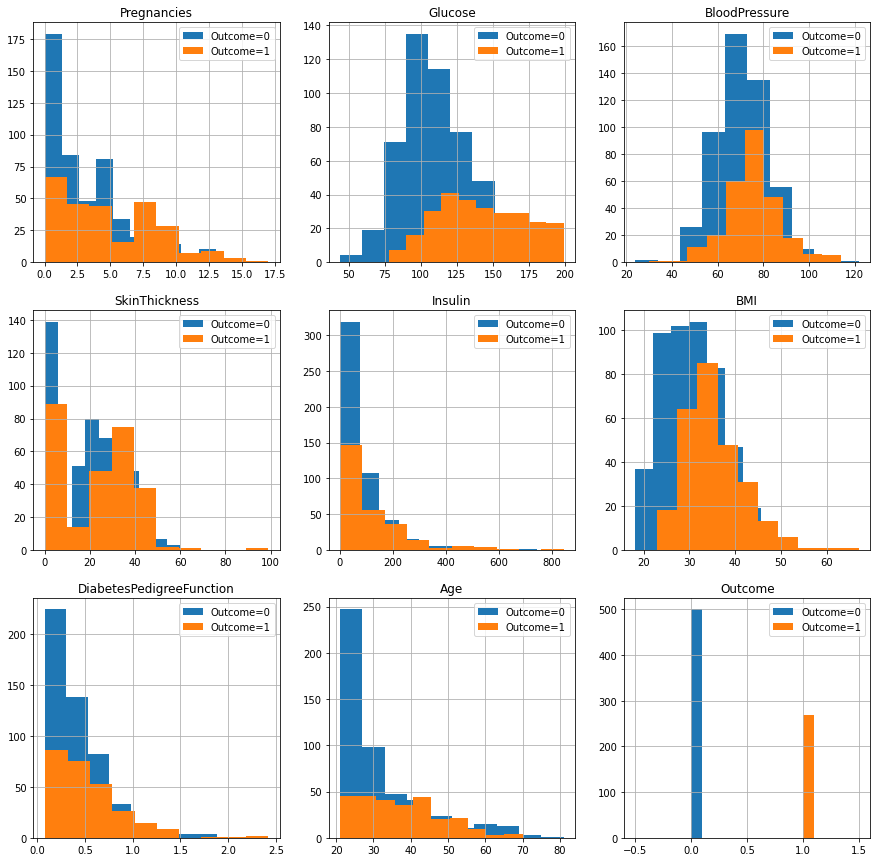

In [16]:
plt.figure(figsize=(15,15))
columns = data.columns
for i, column in enumerate(data.columns):
  plt.subplot(3, 3, i+1)
  data[data['Outcome']==0][column].hist(label='Outcome=0') 
  data[data['Outcome']==1][column].hist(label='Outcome=1') 
  plt.title(column)
  plt.legend(loc='upper right')
plt.show()


**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите BaggingClassifier на деревьях (поставьте параметр base_estimator = DecisionTreeClassifier()) и RandomForest. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

Разделим выборку на train и test

In [17]:
X = data.drop('Outcome',axis=1).to_numpy()
y = data['Outcome'].to_numpy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Функция score выводит значения accuracy, recall и precision

In [19]:
def score(y_pred, y_test):
  return print('Accuracy: ',accuracy_score(y_pred,y_test),', Recall: ',recall_score(y_pred,y_test),', Precision: ',precision_score(y_pred,y_test))

Обучим BaggingClassifier как сказано в задании

In [20]:
bagg=BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=10, random_state=42)
bagg.fit(X_train,y_train)
y_pred=bagg.predict(X_test)
score(y_pred,y_test)

Accuracy:  0.7619047619047619 , Recall:  0.6623376623376623 , Precision:  0.6375


Обучим RandomForestClassifier как сказано в задании

In [21]:
rf=RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
score(y_pred,y_test)

Accuracy:  0.7445887445887446 , Recall:  0.6567164179104478 , Precision:  0.55


Результаты получились примерно одинаковыми с разницей в несколько сотых беггинг лучше, я думаю, что это связано с тем, что эти алгоритмы в принципе похожи , разница между ними в том, что помимо бутстрапа в случайном лесу еще при  построение деревьев на каждом шаге берется случайное подмножество признаков. Также результаты данных алгоритмов во многом полагаются на рандом. Посмотим на результаты метрик в зависимомти от random_state

In [22]:
for r in range(10,70,13):
  rf=RandomForestClassifier(n_estimators=10, random_state=r)
  rf.fit(X_train,y_train)
  y_pred=rf.predict(X_test)
  print('rahdom_state:', r,end='  ')
  score(y_pred,y_test)

rahdom_state: 10  Accuracy:  0.7272727272727273 , Recall:  0.6268656716417911 , Precision:  0.525
rahdom_state: 23  Accuracy:  0.7316017316017316 , Recall:  0.6285714285714286 , Precision:  0.55
rahdom_state: 36  Accuracy:  0.7402597402597403 , Recall:  0.6388888888888888 , Precision:  0.575
rahdom_state: 49  Accuracy:  0.7229437229437229 , Recall:  0.625 , Precision:  0.5
rahdom_state: 62  Accuracy:  0.7402597402597403 , Recall:  0.6428571428571429 , Precision:  0.5625


In [23]:
for r in range(10,70,13):
  bagg=BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=10, random_state=r)
  bagg.fit(X_train,y_train)
  y_pred=bagg.predict(X_test)
  print('rahdom_state:', r,end='  ')
  score(y_pred,y_test)

rahdom_state: 10  Accuracy:  0.7186147186147186 , Recall:  0.5949367088607594 , Precision:  0.5875
rahdom_state: 23  Accuracy:  0.7272727272727273 , Recall:  0.6164383561643836 , Precision:  0.5625
rahdom_state: 36  Accuracy:  0.7532467532467533 , Recall:  0.6533333333333333 , Precision:  0.6125
rahdom_state: 49  Accuracy:  0.7575757575757576 , Recall:  0.6621621621621622 , Precision:  0.6125
rahdom_state: 62  Accuracy:  0.7445887445887446 , Recall:  0.6363636363636364 , Precision:  0.6125


Видно что при значениях 10, 23 лучше RandomForest, при значениях random_state 36, 49, 62 лучше Bagging.

**4. (2 балл)** Для случайного леса проанализируйте значение ROC-AUC на этих же данных в зависимости от изменения параметров:

n_estimators (можно перебрать около 10 значений из отрезка от 10 до 1500)  
min_samples_leaf (сетку значений можете выбрать на ваше усмотрение)  
Постройте соответствующие графики зависимости ROC-AUC от этих параметров. Какие выводы можете сделать?

Построим график зависимоти  ROC-AUC от числа деревьев в RandomForest, для этого возьмем число деревьев из диапозона от 10 до 1500 с шагом 150, на каждом шаге будем строить соответсвующий алгоритм и считать значение ROC-AUC

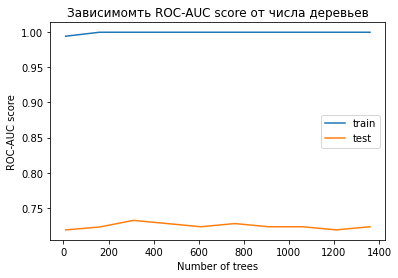

In [24]:
roc_auc_train=[]
roc_auc_test=[]
n_range=range(10,1500,150)
rf=RandomForestClassifier(warm_start=True, random_state=42)
for n in n_range:
  rf.n_estimators=n
  rf.fit(X_train,y_train)
  roc_auc_train.append(roc_auc_score(rf.predict(X_train),y_train))
  roc_auc_test.append(roc_auc_score(rf.predict(X_test),y_test))
plt.figure()
plt.plot(n_range,roc_auc_train, label='train')
plt.plot(n_range,roc_auc_test, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('ROC-AUC score')
plt.title('Зависимомть ROC-AUC score от числа деревьев')
plt.show()

Видно, что даже при больших n roc_auc на тестовой выборке остается примерно на том же уровне, так как random forest не переобучается при большом числе базовых моделей. Подберем n при котором достигается максимум roc-auc на тестовой выборке

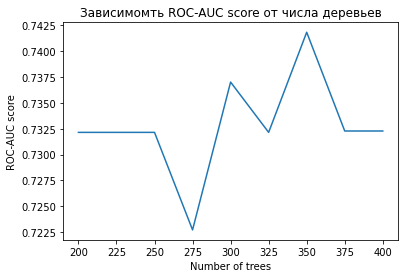

In [25]:
roc_auc=[]
n_range=range(200,401,25)
for n in n_range:
  rf=RandomForestClassifier(n_estimators=n, random_state=42)
  rf.fit(X_train,y_train)
  y_pred=rf.predict(X_test)
  roc_auc.append(roc_auc_score(y_pred,y_test))
plt.figure()
plt.plot(n_range,roc_auc)
plt.xlabel('Number of trees')
plt.ylabel('ROC-AUC score')
plt.title('Зависимомть ROC-AUC score от числа деревьев')
plt.show()

Получается, что лучшее значении ROC-AUC примерно 0,7425 достигается при n_estimators=350

Проделаем тоже самое для min_samples_leaf, сначала возьмем значения из диапозона от 1 до 100 с шагом 5. (n_estimators оставим по умолчанию 100)

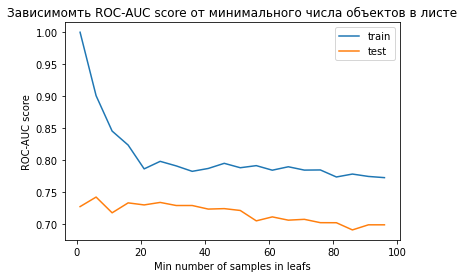

In [26]:
roc_auc_train=[]
roc_auc_test=[]
leafs_range=range(1,100,5)
for l in leafs_range:
  rf=RandomForestClassifier(min_samples_leaf=l, random_state=42)
  rf.fit(X_train,y_train)
  roc_auc_train.append(roc_auc_score(rf.predict(X_train),y_train))
  roc_auc_test.append(roc_auc_score(rf.predict(X_test),y_test))
plt.figure()
plt.plot(leafs_range,roc_auc_train, label='train')
plt.plot(leafs_range,roc_auc_test, label='test')
plt.legend()
plt.xlabel('Min number of samples in leafs')
plt.ylabel('ROC-AUC score')
plt.title('Зависимомть ROC-AUC score от минимального числа объектов в листе')
plt.show()

С ростом min_samples_leaf качесвто ухудшается как на тестовой так и обучающей выборке, что вполне логично, потому что идея RandomForest заключается в построении достаточно глубоких деревьев, а с увелечением min_samples_leaf, глубина деревьев уменьшается. Как видно из графика максимум достигается на промежутке (1,20). Рассмотрим подробней этот промежуток ниже.

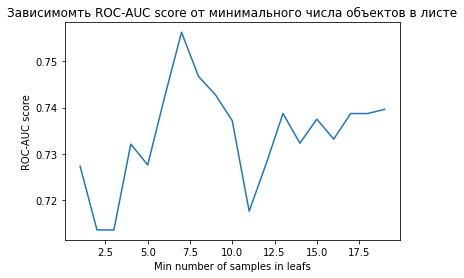

In [27]:
roc_auc=[]
leafs_range=range(1,20)
for l in leafs_range:
  rf=RandomForestClassifier(min_samples_leaf=l,random_state=42)
  rf.fit(X_train,y_train)
  y_pred=rf.predict(X_test)
  roc_auc.append(roc_auc_score(y_pred,y_test))
plt.figure()
plt.plot(leafs_range,roc_auc)
plt.xlabel('Min number of samples in leafs')
plt.ylabel('ROC-AUC score')
plt.title('Зависимомть ROC-AUC score от минимального числа объектов в листе')
plt.show()

Лучшее значении ROC-AUC примерно  достигается при min_samples_leaf=7

In [28]:
rf=RandomForestClassifier(min_samples_leaf=7,random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
roc_auc_score(y_pred,y_test)

0.7562458361092605

**5. (1 балл)** Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим аттрибутом случайного леса в библиотеке sklearn, чтобы построить barplot.

Воспользуемся соответствующим параметром feature_importances_ и построим barplot

Accuracy:  0.7792207792207793 , Recall:  0.6835443037974683 , Precision:  0.675


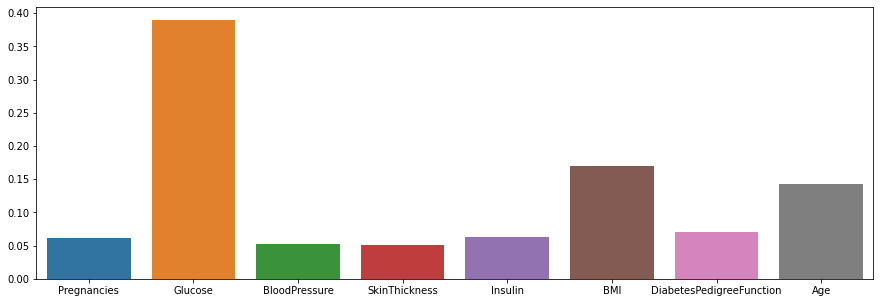

In [30]:
rf=RandomForestClassifier(min_samples_leaf=7, random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
score(y_pred, y_test)
f, ax = plt.subplots(figsize = (15,5))
barplot(x=data.columns[:-1],y=rf.feature_importances_)
plt.show()


По данной диаграмме можно выделить три наиболее важных признака Glucose, BMI, Age.

**6. (2 балла)** Обучите HistGradientBoostingClassifier и GradientBoostingClassifier из sklearn. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

Обучим HistGradientBoostingClassifier и GradientBoostingClassifier из sklearn

In [31]:
gb = GradientBoostingClassifier( random_state=42)
gb.fit(X_train, y_train)
y_pred=gb.predict(X_test)
score(y_test,y_pred)

Accuracy:  0.7402597402597403 , Recall:  0.7 , Precision:  0.6086956521739131


In [32]:
hist_b = HistGradientBoostingClassifier( random_state=42)
hist_b.fit(X_train, y_train)
y_pred=hist_b.predict(X_test)
score(y_test,y_pred)

Accuracy:  0.7489177489177489 , Recall:  0.7 , Precision:  0.6222222222222222


Основная разница между этими алгоритмами заключается в том, что при построении деревьев в HistGradientBoosting при поиске лучшего предиката перебираются не все значения признака, а значения гистограммы этого признака, что увеличивает скорость построяния деревьев.  Также благодаря использованию гистограмм HistGradientBoosting позволяет работать с данными, которые содержат пропуски. Как написано в документации, преимущества HistGradientBoosting в скорости проявляются при больших данных n_samples >= 10 000, в нашей выборке всего 768 объектов.

Подберем подходящее число деревьев для GradientBoostingClassifier, как мы делали это на семинаре, по очереди переберем число деревьев из диапозона от 1 до 300 и построим график зависимости accuracy score на обучающей и тестовой выборке от числа деревьев 

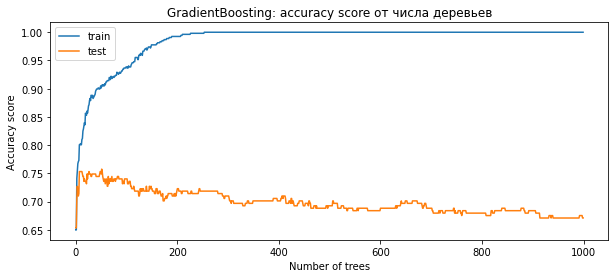

In [33]:

MAX_ESTIMATORS = 1000
gb = GradientBoostingClassifier(warm_start=True, random_state=42)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gb.n_estimators = i
    gb.fit(X_train, y_train)
    #err_train_gb.append(f1_score(gb.predict(X_train), y_train))
    #err_test_gb.append(f1_score(gb.predict(X_test), y_test))
    err_train_gb.append(gb.score(X_train, y_train))
    err_test_gb.append(gb.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(err_train_gb, label='train')
plt.plot(err_test_gb, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('GradientBoosting: accuracy score от числа деревьев')
plt.show()

Видно, что при больших n gradient boosting переобучается.

Максисмум accuracy score  на тестовой выборке достигается на промежутке (1,50) рассмотрим его подробней только теперь в качестве метрики возьмем F1 меру.

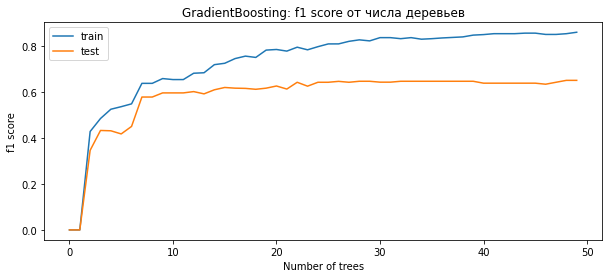

In [34]:
from sklearn.metrics import f1_score
MAX_ESTIMATORS = 50
gb = GradientBoostingClassifier(warm_start=True, random_state=42)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gb.n_estimators = i
    gb.fit(X_train, y_train)
    err_train_gb.append(f1_score(gb.predict(X_train), y_train))
    err_test_gb.append(f1_score(gb.predict(X_test), y_test))
    #err_train_gb.append(gb.score(X_train, y_train))
    #err_test_gb.append(gb.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(err_train_gb, label='train')
plt.plot(err_test_gb, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('f1 score')
plt.title('GradientBoosting: f1 score от числа деревьев')
plt.show()

In [35]:
#Лучший алгоритм
gb = GradientBoostingClassifier( n_estimators=23, random_state=42)
gb.fit(X_train, y_train)
y_pred=gb.predict(X_test)
score(y_pred, y_test)
print('ROC-AUC score: ', roc_auc_score(y_pred,y_test))

Accuracy:  0.7489177489177489 , Recall:  0.6341463414634146 , Precision:  0.65
ROC-AUC score:  0.7231134391880832


Получился достаточно сбаланированный алгоритм в отношении использованных метрик

HistGradientBoostingClassifier не содержит параметра n_estimators, так что не понятно какое количесвто деревьев и как надо подбирать для этого метода. Я, прочитав описание этого класса, так и не нашла параметра или атрибута у этого класса, отвечающего за число деревьев, аналогичного n_estimators GradientBoostingClassifier. HistGradientBoostingClassifier содержит параметр max_iter, который вроде бы похож на то,что требуется. Описание этого параметра: The maximum number of iterations of the boosting process, i.e. the maximum number of trees for binary classification. Попробуем подобрать его, будем использовать тот же алгорит,что при подборе n_estimators GradientBoostingClassifier

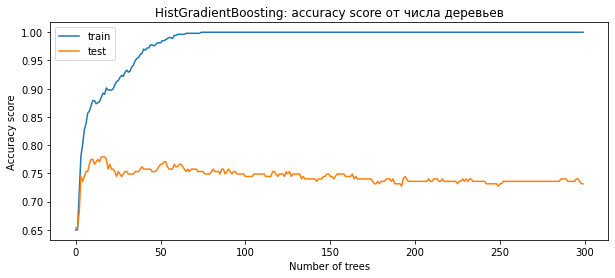

In [36]:
MAX_ESTIMATORS = 300
hist_b = HistGradientBoostingClassifier(warm_start=True, random_state=42)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    hist_b.max_iter=i
    hist_b.fit(X_train, y_train)
    err_train_gb.append(hist_b.score(X_train, y_train))
    err_test_gb.append(hist_b.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(err_train_gb, label='train')
plt.plot(err_test_gb, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('HistGradientBoosting: accuracy score от числа деревьев')
plt.show()

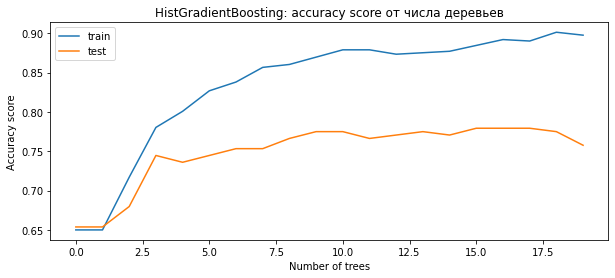

In [37]:
MAX_ESTIMATORS = 20
hist_b = HistGradientBoostingClassifier(warm_start=True, random_state=42)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    hist_b.max_iter=i
    hist_b.fit(X_train, y_train)
    err_train_gb.append(hist_b.score(X_train, y_train))
    err_test_gb.append(hist_b.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(err_train_gb, label='train')
plt.plot(err_test_gb, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('HistGradientBoosting: accuracy score от числа деревьев')
plt.show()

In [38]:
#лучший алгоритм
hist_b = HistGradientBoostingClassifier( max_iter=16,random_state=42)
hist_b.fit(X_train, y_train)
y_pred=hist_b.predict(X_test)
score(y_test,y_pred)
print('ROC-AUC score: ', roc_auc_score(y_pred,y_test))

Accuracy:  0.7792207792207793 , Recall:  0.7 , Precision:  0.6746987951807228
ROC-AUC score:  0.7562683165092804


Получился сбалансированный алгоритм с высокими показателями используемых метрик

Так как сначала я не поняла какой параметр отвечает за число деревьев, да и max_iter все же, мне кажется, имеет другой смысл нежели n_estimators я решила подобрать параметр learning_rate.

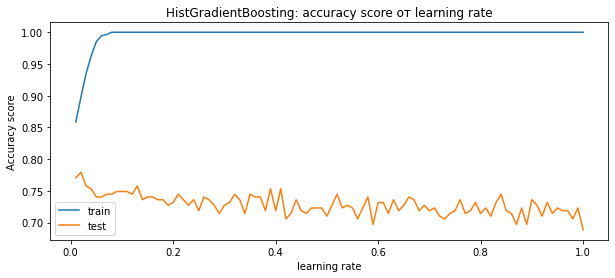

In [39]:
learning_rates=[i/100 for i in range(1,101)]
hist_b = HistGradientBoostingClassifier(warm_start=False, random_state=42)
err_train_gb = []
err_test_gb = []
for i in learning_rates:
    hist_b.learning_rate=i
    hist_b.fit(X_train, y_train)
    err_train_gb.append(hist_b.score(X_train, y_train))
    err_test_gb.append(hist_b.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(learning_rates,err_train_gb,  label='train')
plt.plot(learning_rates,err_test_gb, label='test')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('Accuracy score')
plt.title('HistGradientBoosting: accuracy score от learning rate')
plt.show()

Рассмотри промежуток (0, 0.1), где достигается максимум подробней

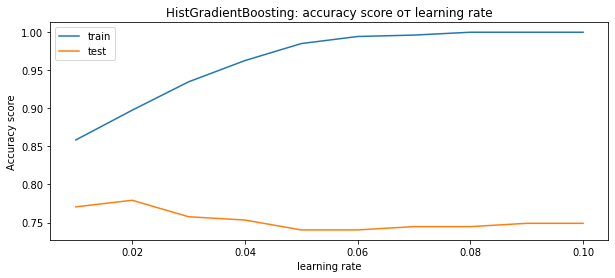

In [40]:
learning_rates=[i/100 for i in range(1,11)]
hist_b = HistGradientBoostingClassifier(warm_start=False, random_state=42)
err_train_gb = []
err_test_gb = []
for i in learning_rates:
    hist_b.learning_rate=i
    hist_b.fit(X_train, y_train)
    err_train_gb.append(hist_b.score(X_train, y_train))
    err_test_gb.append(hist_b.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(learning_rates,err_train_gb,  label='train')
plt.plot(learning_rates,err_test_gb, label='test')
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('Accuracy score')
plt.title('HistGradientBoosting: accuracy score от learning rate')
plt.show()

In [41]:
#лучший алгоритм
hist_b = HistGradientBoostingClassifier( learning_rate=0.02,random_state=42)
hist_b.fit(X_train, y_train)
y_pred=hist_b.predict(X_test)
score(y_test,y_pred)
print('ROC-AUC score: ', roc_auc_score(y_pred,y_test))

Accuracy:  0.7792207792207793 , Recall:  0.725 , Precision:  0.6666666666666666
ROC-AUC score:  0.7569444444444444


Получился достаточно сбаланированный алгоритм с высокими показателями использованных метрик

На всякий случай продемонстрирую, что атрибут n_trees_per_iteration_ также не аналогичен n_estimators

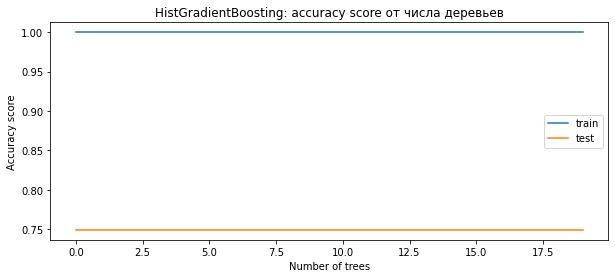

In [42]:
MAX_ESTIMATORS = 20
hist_b = HistGradientBoostingClassifier( random_state=42)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    hist_b.n_trees_per_iteration_=i
    hist_b.fit(X_train, y_train)
    err_train_gb.append(hist_b.score(X_train, y_train))
    err_test_gb.append(hist_b.score(X_test, y_test))
plt.figure(figsize=(10, 4))
plt.plot(err_train_gb, label='train')
plt.plot(err_test_gb, label='test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.title('HistGradientBoosting: accuracy score от числа деревьев')
plt.show()

**7. (1.5 балла)** Вспомните, что представляет собой стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классфикатор из уже вами изученных на курсе. Как final_estimator используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

Как я поняла, StackingClassifier работает так: сначала с помощью estimators (base_learners) строятся предсказания, они используются, как дополнительные признаки, то есть final_estimator в нашем случае лог-регресссия работает как обычная лог-регрессия, только на выборке с дополнительними признаками, полученными с помощью  estimators.

Возьмем за base_learners сначала Bagging и KNN, посмотрим на результаты метрик этих классификаторов в отдельности

In [43]:
base_learners_1 = [
                 ('Bagging', BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=10, random_state=42)),
                 ('KNN',KNeighborsClassifier())
                 ]

In [44]:
knn=KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print('KNN')
score(y_test,y_pred)

KNN
Accuracy:  0.670995670995671 , Recall:  0.5625 , Precision:  0.5232558139534884


In [45]:
bagg=BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators=10, random_state=42)
bagg.fit(X_train, y_train)
y_pred=bagg.predict(X_test)
print('Bagging')
score(y_test,y_pred)

Bagging
Accuracy:  0.7619047619047619 , Recall:  0.6375 , Precision:  0.6623376623376623


Теперь обучим StackingClassifier

In [46]:
sclf=StackingClassifier(estimators=base_learners_1, final_estimator=LogisticRegression())
sclf.fit(X_train, y_train)
y_pred=sclf.predict(X_test)
print('Стекинг Bagging и KNN ')
score(y_test,y_pred)

Стекинг Bagging и KNN 
Accuracy:  0.7272727272727273 , Recall:  0.5375 , Precision:  0.6231884057971014


По сравнению с knn качесвто улучшилось, а по сравненению с беггингом уменьшилось. 

Теперь за base_learners возьмем RandomForest и LinearSVC

In [47]:
base_learners_2 = [
                 ('RandomForest',RandomForestClassifier(min_samples_leaf=7, random_state=33)),
                 ('LinearSVC',LinearSVC(random_state=33))
                 ]

In [48]:
rf=RandomForestClassifier(min_samples_leaf=7, random_state=33)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print('RandomForest')
score(y_pred, y_test)

RandomForest
Accuracy:  0.7575757575757576 , Recall:  0.6538461538461539 , Precision:  0.6375


In [49]:
svc=LinearSVC(random_state=33)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('LinearSVC')
score(y_pred, y_test)

LinearSVC
Accuracy:  0.696969696969697 , Recall:  0.5694444444444444 , Precision:  0.5125


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
sclf=StackingClassifier(estimators=base_learners_2, final_estimator=LogisticRegression())
sclf.fit(X_train, y_train)
y_pred=sclf.predict(X_test)
print('Стекинг RandomForest и LinearSVC')
score(y_test,y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Стекинг RandomForest и LinearSVC
Accuracy:  0.7575757575757576 , Recall:  0.6625 , Precision:  0.6463414634146342


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Качество LinerSVC было низким, но в итоге с помошью стекинга accuracy осталась та же, что и RandomForest, а показатели precision и recall удалось увеличить на 1 сотую.